In [10]:
import os
import pvc1_loader
import separable_net
import torch
import xception

data_root = '.'
device = torch.device('cuda')

trainset = pvc1_loader.PVC1(os.path.join(data_root, 'data/crcns-ringach-data'), 
                            split='train', 
                            nt=32, 
                            ntau=9,
                            nframedelay=2)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=12, 
                                          shuffle=False)

subnet = xception.Xception(start_kernel_size=7, 
                           nblocks=0, 
                           nstartfeats=64)
subnet.to(device=device)

net = separable_net.LowRankNet(subnet, 
                               trainset.total_electrodes, 
                               64, 
                               53, 
                               53, 
                               trainset.ntau).to(device)

net.to(device=device)

LowRankNet(
  (subnet): Xception(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
    (relu): ReLU(inplace=True)
  )
)

In [ ]:
"""
i = 0
total = 0
total_sq = 0
n = 0
for X, M, Y in trainloader:
    print(i)
    n = n + i
    if n % 10 == 0:
        print(i)
    total += X.sum(axis=0).sum(axis=1)
    total_sq += (X ** 2).sum(axis=0).sum(axis=1)
    i += X.shape[0] * X.shape[2]
"""

import matplotlib.pyplot as plt
#plt.imshow((total[:, :, :] / i).permute(1, 2, 0) / 255)
#total.shape
(total[:, :, :] / i).mean(dim=1).mean(dim=1)

tensor([-0.0049,  0.0055, -0.0050])

In [11]:
net.load_state_dict(torch.load('models/shallow/xception.ckpt-0212096-2020-12-15 10-33-19.873072.pt'))

<All keys matched successfully>

In [12]:
(subnet.conv1.weight > 0).sum(axis=0)

tensor([[[21, 24, 29, 23, 22, 27, 10],
         [42, 48, 39, 45, 37, 39, 22],
         [44, 45, 41, 39, 39, 40, 24],
         [50, 48, 41, 38, 40, 41, 24],
         [52, 53, 45, 45, 45, 47, 33],
         [48, 53, 48, 48, 43, 40, 28],
         [61, 60, 59, 57, 53, 50, 50]],

        [[ 8, 14, 21, 16, 17, 27, 13],
         [15, 26, 28, 25, 26, 31, 32],
         [ 8, 17, 16, 19, 18, 22, 14],
         [ 7, 14, 12, 15, 17, 18, 11],
         [ 7, 10, 14, 16, 18, 16, 12],
         [ 3,  1,  5,  8, 10,  7,  6],
         [ 4,  1,  3,  6,  2,  4,  9]],

        [[18, 24, 23, 21, 21, 25, 21],
         [41, 40, 35, 41, 40, 38, 37],
         [40, 38, 35, 33, 35, 37, 36],
         [49, 41, 41, 38, 39, 41, 44],
         [50, 45, 42, 44, 48, 41, 45],
         [50, 41, 40, 37, 41, 36, 45],
         [56, 49, 47, 43, 48, 49, 48]]], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

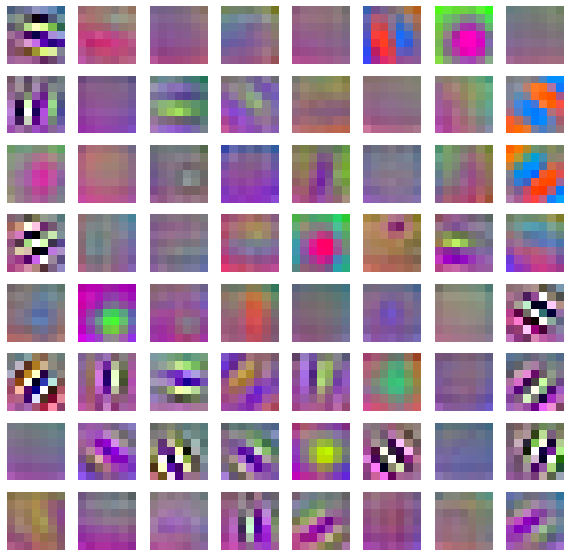

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(2*subnet.conv1.weight[i, :, :, :].permute((1, 2, 0)).cpu().detach().numpy() + .5)
    plt.axis('off')

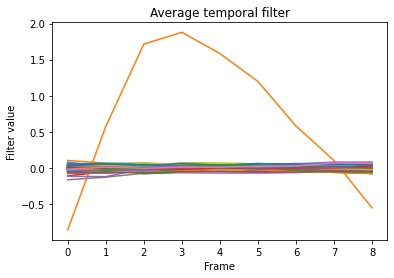

In [23]:
plt.plot(net.wt.cpu().detach())
plt.xlabel('Frame')
plt.ylabel('Filter value')
plt.title('Average temporal filter')
plt.box('off')

In [32]:
net.wt[:, 31]

tensor([-0.8605,  0.5710,  1.7143,  1.8800,  1.5854,  1.1979,  0.5814,  0.1018,
        -0.5546], device='cuda:0', grad_fn=<SelectBackward>)

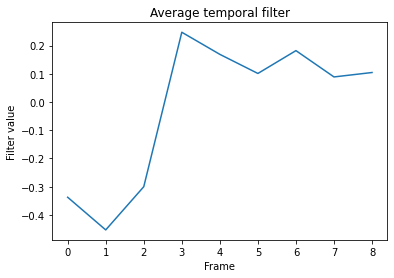

In [37]:
import numpy as np
idx = np.ones(net.wt.shape[1], dtype=np.bool)
idx[31] = False

plt.plot(net.wt[:, idx].sum(axis=1).cpu().detach())
plt.xlabel('Frame')
plt.ylabel('Filter value')
plt.title('Average temporal filter')
plt.box('off')

In [40]:
testset = pvc1_loader.PVC1(os.path.join(data_root, 'data/crcns-ringach-data'), 
                            split='report', 
                            nt=32, 
                            ntau=9,
                            nframedelay=0)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=12, 
                                         shuffle=False,
                                         pin_memory=True)

In [45]:
from torchvision import transforms
import torch.nn.functional as F

def ds():
    downsample_filt = torch.tensor([[.25, .5, .25], [.5, 1.0, .5], [.25, .5, .25]]).view(1, 1, 3, 3).to(device=device)
    downsample_filt /= 4.0

    def d(X):
        return F.conv2d(X.reshape(-1, 1, X.shape[3], X.shape[4]), 
                        downsample_filt, 
                        stride=2).reshape(X.shape[0], 
                            X.shape[1], 
                            X.shape[2], 
                            X.shape[3]//2,
                            X.shape[4]//2)

    return d

# Downsampling helps reduce compute and decreases the 
rc = transforms.Compose([transforms.RandomCrop(223), 
                         ds()])

In [55]:
print(labels.shape)
print(M.shape)
print(fwd.shape)
M[:, rg].shape

torch.Size([12, 25, 32])
torch.Size([12, 127])
torch.Size([12, 25, 32])


torch.Size([12, 25])

In [57]:
totals = 0
n = 0

n = torch.zeros(trainset.total_electrodes, device=device)
total_labels = torch.zeros_like(n)
total_labels_squared = torch.zeros_like(n)
total_labels_sse = torch.zeros_like(n)

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        print(f"Loading batch {i}")
        X, M, labels = data
        X, M, labels = X.to(device), M.to(device), labels.to(device)

        X = rc(X)
        fwd = net.forward((X, M))
        
        rg = M.any(axis=0)
        labels = labels[:, rg, :]

        n += M.sum(axis=0)
        M = M[:, rg]

        total_labels[rg] += (M.reshape(M.shape[0], M.shape[1], 1) * labels).sum(0).sum(1)
        total_labels_squared[rg] += (M.reshape(M.shape[0], M.shape[1], 1) * (labels ** 2)).sum(0).sum(1)
        total_labels_sse[rg] += ((M.reshape(M.shape[0], M.shape[1], 1) * (labels - fwd)) ** 2).sum(0).sum(1)

Loading batch 0
Loading batch 1
Loading batch 2
Loading batch 3
Loading batch 4
Loading batch 5
Loading batch 6
Loading batch 7
Loading batch 8
Loading batch 9
Loading batch 10
Loading batch 11
Loading batch 12
Loading batch 13
Loading batch 14
Loading batch 15
Loading batch 16
Loading batch 17
Loading batch 18
Loading batch 19
Loading batch 20
Loading batch 21
Loading batch 22
Loading batch 23
Loading batch 24
Loading batch 25
Loading batch 26
Loading batch 27
Loading batch 28
Loading batch 29
Loading batch 30
Loading batch 31
Loading batch 32
Loading batch 33
Loading batch 34
Loading batch 35
Loading batch 36
Loading batch 37
Loading batch 38
Loading batch 39
Loading batch 40
Loading batch 41
Loading batch 42
Loading batch 43
Loading batch 44
Loading batch 45
Loading batch 46
Loading batch 47
Loading batch 48
Loading batch 49
Loading batch 50
Loading batch 51
Loading batch 52
Loading batch 53
Loading batch 54
Loading batch 55
Loading batch 56
Loading batch 57
Loading batch 58
Loading

Text(0.5, 1.0, 'Downsampled model with pre-trained filters')

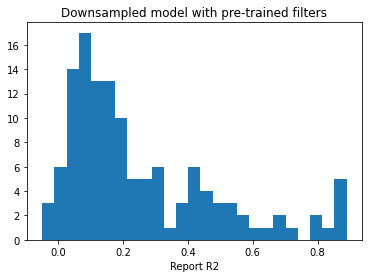

In [58]:
variance_baseline = total_labels_squared / n - (total_labels / n / labels.shape[2]) ** 2
variance_baseline

variance_after = total_labels_sse / n

r2 = 1 - variance_after / variance_baseline
plt.hist(r2.cpu().squeeze().numpy(), 25)
plt.xlabel('Report R2')
plt.title('Downsampled model with pre-trained filters')

In [60]:
r2.mean()

tensor(0.2520, device='cuda:0')

In [65]:
print(r2[testset.nrepeats == 1].mean())
print(r2[testset.nrepeats == 10].mean())

tensor(0.1725, device='cuda:0')
tensor(0.6117, device='cuda:0')


In [59]:
import wandb
import numpy as np

wandb.init(project="crcns-test", config={
    "architecture": "xception-2d",
    "dataset": "pvc1",
    "pretrained": True,
    "downsampled": True
})
config = wandb.config
#r2 = r2.cpu().detach().numpy()
r2 = r2[~np.isnan(r2)]
wandb.log({"valr2": r2})

tensor(0.2520, device='cuda:0')